In [1]:
# import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import seaborn as sns
import plotly.graph_objects as go
import plotly.graph_objects as go
from sktime.forecasting.model_selection import temporal_train_test_split
from tabulate import tabulate

%matplotlib inline

import warnings
import datetime

warnings.filterwarnings("ignore")

In [2]:
huwaei=pd.read_csv('training_2.csv')
cols=[i for i in huwaei.columns if i not in ['timestamp']]
for col in cols:
    huwaei[col]=pd.to_numeric(huwaei[col])
huwaei['timestamp'] = pd.to_datetime(huwaei['timestamp'])

huwaei.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      4032 non-null   datetime64[ns]
 1   kpi_value      4032 non-null   float64       
 2   anomaly_label  4032 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 94.6 KB


In [3]:
huwaei

,timestamp,kpi_value,anomaly_label
0,2014-04-01 00:00:00,0.000000,0
1,2014-04-01 00:05:00,0.000000,0
2,2014-04-01 00:10:00,0.000000,0
3,2014-04-01 00:15:00,0.000000,0
4,2014-04-01 00:20:00,0.000000,0
...,...,...,...
4027,2014-04-14 23:35:00,0.460912,0
4028,2014-04-14 23:40:00,0.472003,0
4029,2014-04-14 23:45:00,0.000000,0
4030,2014-04-14 23:50:00,0.000000,0


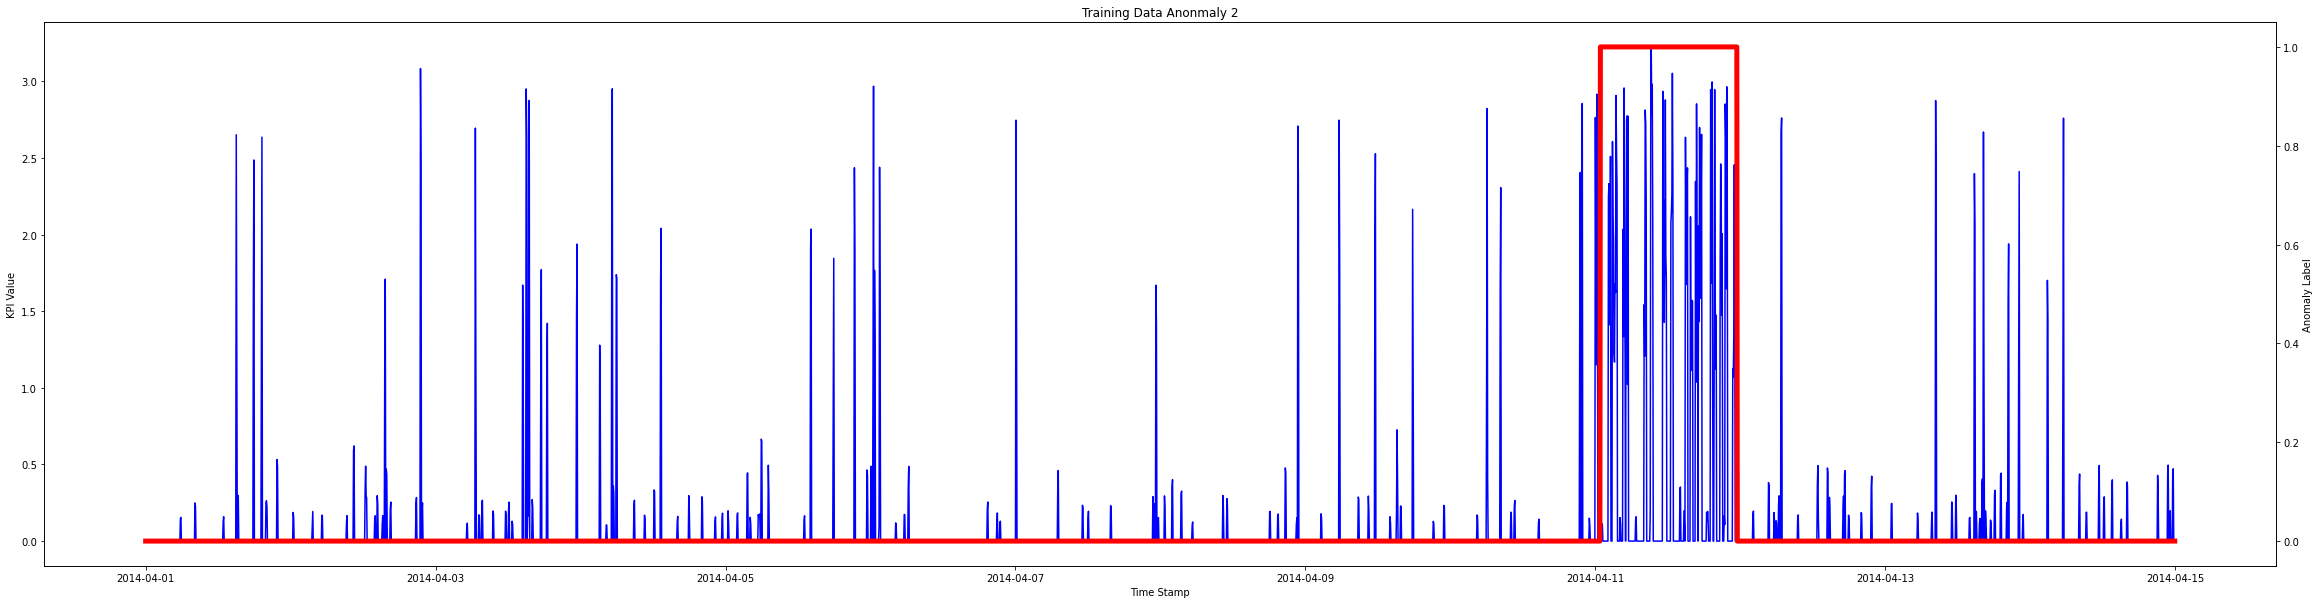

In [4]:
fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
ax2d.plot(huwaei['timestamp'], huwaei['kpi_value'], color='blue')
ax2a.plot(huwaei['timestamp'], huwaei['anomaly_label'], color='red', linewidth='5')
ax2d.set_xlabel('Time Stamp')
ax2d.set_ylabel('KPI Value')
ax2a.set_ylabel('Anomaly Label')
ax2d.title.set_text('Training Data Anonmaly 2')

# Huwaei

In [5]:
huwaei_dataset=huwaei[['timestamp', 'kpi_value']]
#dataset

# convert the column (it's a string) to datetime type
datetime_series = pd.to_datetime(huwaei_dataset['timestamp'])

# create datetime index passing the datetime series
datetime_index = pd.DatetimeIndex(datetime_series.values)

# datetime_index
period_index = pd.PeriodIndex(datetime_index, freq='S')

# period_index
huwaei_dataset = huwaei_dataset.set_index(period_index)

# we don't need the column anymore
huwaei_dataset.drop('timestamp',axis=1,inplace=True)

huwaei_dataset.head()
# print(len(dataset))

,kpi_value
2014-04-01 00:00:00,0.0
2014-04-01 00:05:00,0.0
2014-04-01 00:10:00,0.0
2014-04-01 00:15:00,0.0
2014-04-01 00:20:00,0.0


In [6]:
contamination=5.268
contamination=contamination/100

# importing the isloation forest
from sklearn.neighbors import LocalOutlierFactor

# copying dataset
isf_dataset = huwaei_dataset.copy()

# initializing Isolation Forest
clf = LocalOutlierFactor(n_neighbors=10, contamination=contamination)

# training
clf.fit(isf_dataset)

# finding anomalies
isf_dataset['Anomaly'] = clf.fit_predict(isf_dataset) 

# saving anomalies to a separate dataset for visualization purposes
# anomalies_single = isf_dataset.query('Anomaly == -1')
anomalies=isf_dataset

In [7]:
total_contamination=len(anomalies)

In [8]:
output=anomalies

In [9]:
anomalies

,kpi_value,Anomaly
2014-04-01 00:00:00,0.000000,1
2014-04-01 00:05:00,0.000000,1
2014-04-01 00:10:00,0.000000,1
2014-04-01 00:15:00,0.000000,1
2014-04-01 00:20:00,0.000000,1
...,...,...
2014-04-14 23:35:00,0.460912,-1
2014-04-14 23:40:00,0.472003,1
2014-04-14 23:45:00,0.000000,1
2014-04-14 23:50:00,0.000000,1


In [10]:
anomalies["Anomaly"]=anomalies["Anomaly"].replace(1, 0) #No Anomalies
anomalies["Anomaly"]=anomalies["Anomaly"].replace(-1, 1) #Anomalies
anomalies

,kpi_value,Anomaly
2014-04-01 00:00:00,0.000000,0
2014-04-01 00:05:00,0.000000,0
2014-04-01 00:10:00,0.000000,0
2014-04-01 00:15:00,0.000000,0
2014-04-01 00:20:00,0.000000,0
...,...,...
2014-04-14 23:35:00,0.460912,1
2014-04-14 23:40:00,0.472003,0
2014-04-14 23:45:00,0.000000,0
2014-04-14 23:50:00,0.000000,0


In [11]:
moving_average=anomalies['Anomaly'].rolling(50).mean()
moving_average

2014-04-01 00:00:00     NaN
2014-04-01 00:05:00     NaN
2014-04-01 00:10:00     NaN
2014-04-01 00:15:00     NaN
2014-04-01 00:20:00     NaN
                       ... 
2014-04-14 23:35:00    0.06
2014-04-14 23:40:00    0.06
2014-04-14 23:45:00    0.06
2014-04-14 23:50:00    0.06
2014-04-14 23:55:00    0.06
Freq: S, Name: Anomaly, Length: 4032, dtype: float64

In [12]:
moving_average.min()

0.0

In [13]:
moving_average.std()

0.0589193802981493

In [14]:
threshold_6sigma=6*moving_average.std()
threshold_60percentmax=0.6*moving_average.max()

In [15]:
threshold_6sigma

0.35351628178889577

In [16]:
threshold_60percentmax

0.20400000000000001

In [17]:
moving_average.max()

0.34

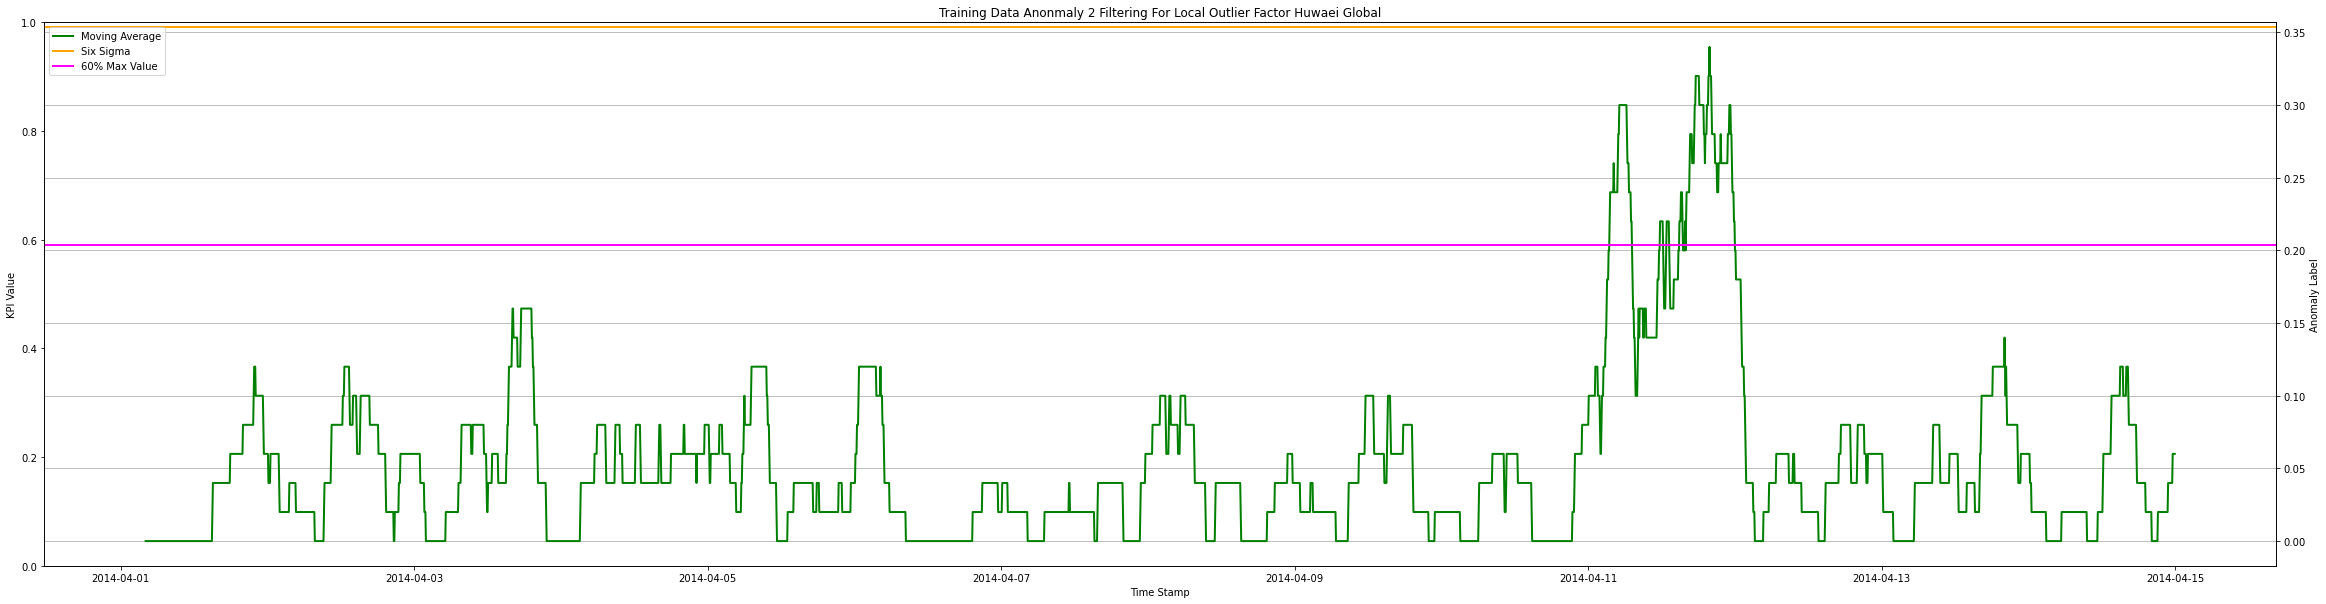

In [18]:
fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
#ax2d.plot(huwaei['timestamp'], huwaei['kpi_value'], color='blue')
#ax2a.plot(huwaei['timestamp'], huwaei['anomaly_label'], color='red', linewidth='5')
ax2a.plot(huwaei['timestamp'], moving_average, color='green', linewidth='2')
ax2a.axhline(threshold_6sigma, color='orange', linewidth='2') # Line for the six sigma
ax2a.axhline(threshold_60percentmax, color='magenta', linewidth='2') # Line for the 60% the highest value
ax2d.set_xlabel('Time Stamp')
ax2d.set_ylabel('KPI Value')
ax2a.set_ylabel('Anomaly Label')
ax2a.legend(['Moving Average', 'Six Sigma', '60% Max Value'], loc='upper left')
plt.grid()
ax2d.title.set_text('Training Data Anonmaly 2 Filtering For Local Outlier Factor Huwaei Global')
plt.savefig('Training Data Anonmaly 2 Filtering For Local Outlier Factor Huwaei Global') 

In [19]:
moving_average=moving_average.dropna(how="all")
moving_average

2014-04-01 04:05:00    0.00
2014-04-01 04:10:00    0.00
2014-04-01 04:15:00    0.00
2014-04-01 04:20:00    0.00
2014-04-01 04:25:00    0.00
                       ... 
2014-04-14 23:35:00    0.06
2014-04-14 23:40:00    0.06
2014-04-14 23:45:00    0.06
2014-04-14 23:50:00    0.06
2014-04-14 23:55:00    0.06
Freq: S, Name: Anomaly, Length: 3983, dtype: float64

In [20]:
len(moving_average)

3983

In [21]:
threshold_60percentmax

0.20400000000000001

In [22]:
n=0
a=0

new_anomalies_60percentmax=[]

for i in range(len(moving_average)):
    if moving_average[i] <= 0.18:
        n=n+1
        t=0
        new_anomalies_60percentmax.append(t)
    elif moving_average[i] > 0.18:
        a=a+1
        t=1
        new_anomalies_60percentmax.append(t)

        

        
print(f"Number of no anomalies: {n}")
print(f"Number of anomalies: {a}")

Number of no anomalies: 3807
Number of anomalies: 176


In [23]:
print(len(huwaei['timestamp']))
print(len(new_anomalies_60percentmax))

4032
3983


In [24]:
labeled_anomalies=huwaei['anomaly_label'][4032-3983:4032]

In [25]:
labeled_anomalies=labeled_anomalies.reset_index(drop=True)
labeled_anomalies

0       0
1       0
2       0
3       0
4       0
       ..
3978    0
3979    0
3980    0
3981    0
3982    0
Name: anomaly_label, Length: 3983, dtype: int64

In [26]:
new_anomalies_60percentmax # New Anomalies from moving average
labeled_anomalies # Labeled Anomalies

0       0
1       0
2       0
3       0
4       0
       ..
3978    0
3979    0
3980    0
3981    0
3982    0
Name: anomaly_label, Length: 3983, dtype: int64

In [27]:
tp60m=0
fp60m=0
tn60m=0
fn60m=0
for i in range(len(labeled_anomalies)):
    if new_anomalies_60percentmax[i] == 1 and labeled_anomalies[i] == 1:
            tp60m=tp60m+1
    elif new_anomalies_60percentmax[i] == 1 and labeled_anomalies[i] != 1:
            fp60m=fp60m+1
    elif new_anomalies_60percentmax[i] != 1 and labeled_anomalies[i] == 1:
            fn60m=fn60m+1
    elif new_anomalies_60percentmax[i] != 1 and labeled_anomalies[i] != 1:
            tn60m=tn60m+1

In [28]:
print("THIS IS FROM USING THE THRESHOLD AS 60% OF THE MAXIMUM VALUES OF THE MOVING AVERAGE")
print("###################################################################################")
print(f"Number of True Positives: {tp60m}")
print(f"Number of False Positives: {fp60m}")
print(f"Number of True Negatives: {tn60m}")
print(f"Number of False Negatives: {fn60m}")
print("###################################")

precision_60m=tp60m/(tp60m+fp60m)
recall_60m=tp60m/(tp60m+fn60m)
F1_Score_60m=(2*precision_60m*recall_60m)/(precision_60m+recall_60m)

print(f"Precision: {round(precision_60m,3)}")
print(f"Recall: {round(recall_60m,3)}")
print(f"F1 Score: {round(F1_Score_60m,3)}")

THIS IS FROM USING THE THRESHOLD AS 60% OF THE MAXIMUM VALUES OF THE MOVING AVERAGE
###################################################################################
Number of True Positives: 168
Number of False Positives: 8
Number of True Negatives: 3703
Number of False Negatives: 104
###################################
Precision: 0.955
Recall: 0.618
F1 Score: 0.75
